<a href="https://colab.research.google.com/github/wangyouzhong/MLStudy/blob/master/Power_Prediction_MultiTask_Incremental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
import io
import pandas as pd

from google.colab import files

import numpy as np
from datetime import date, timedelta

In [45]:
TRAIN_DS_START = date(2019,1,8)
TRAIN_DS_END = date(2019,1,31)
VALIDATE_DS_START = date(2019,2,1)
VALIDATE_DS_END = date(2019,3,31)

NUM_PREVIOUS_DAYS = 7

In [3]:
# add daily sum and time bucket ratio to daily sum as features
NUM_TIME_BUCKETS = 96
START_INDEX_FEATURES = NUM_TIME_BUCKETS

def data_preprocess(df, level, train_ds_end = None):
  df.columns = ['Id', 'Date'] + [f'TB{i}' for i in range(1, NUM_TIME_BUCKETS+1)]
  df['Date'] = pd.to_datetime(df['Date']).dt.date

  # Normalize data
  if level == 3: # normalized by each node
    df = df.set_index(['Id'])

    df_groupby = df[df['Date'] <= train_ds_end].drop(columns=['Date']).groupby(['Id'])
    df_max = df_groupby.max()+1
    df_min = df_groupby.min()-1
    df = df.join(df_max, rsuffix='_max').join(df_min, rsuffix='_min').reset_index()
    for i in range(1, NUM_TIME_BUCKETS+1):
      df[f'TB{i}'] = (df[f'TB{i}'] - df[f'TB{i}_min']) / (df[f'TB{i}_max'] - df[f'TB{i}_min'])
  else: # normalized globally
    df_max = df.iloc[:,2:].max()+1
    df_min = df.iloc[:,2:].min()-1
    for i in range(1, NUM_TIME_BUCKETS+1):
      df[f'TB{i}'] = (df[f'TB{i}'] - df_min[f'TB{i}']) / (df_max[f'TB{i}'] - df_min[f'TB{i}'])

  # Add daily sum features and time bucket ratio to daily sum
  df['Day_Sum'] = df.apply(lambda row: np.sum(row[2:NUM_TIME_BUCKETS+2]) / NUM_TIME_BUCKETS, axis=1)
  for i in range(1, NUM_TIME_BUCKETS+1):
    df[f'TB{i}_Ratio'] = df.apply(lambda row: row[f'TB{i}'] / row['Day_Sum'], axis=1)

  if level == 3:
    global START_INDEX_FEATURES
    START_INDEX_FEATURES = df.shape[1] - 2

    # Add ID and Weekday as one hot features
    df = pd.concat(
      [
        df, 
        pd.get_dummies(df['Id'], prefix='Id'),
        pd.get_dummies(df.apply(lambda row: row['Date'].weekday(), axis=1), prefix='Weekday')
      ],
      axis=1)

  return df

def data_shift_days(df, days_delta):
  df['Date'] = df['Date'] + pd.Timedelta(days=days_delta)
  return df

In [4]:
uploaded1 = files.upload()

Saving 131151000000000965.csv to 131151000000000965.csv


In [5]:
df_l1 = pd.read_csv(io.BytesIO(uploaded1['131151000000000965.csv']), header=None)
df_l1 = data_preprocess(df_l1, 1).drop(columns=['Id'])
df_l1

,Date,TB1,TB2,TB3,TB4,TB5,TB6,TB7,TB8,TB9,TB10,TB11,TB12,TB13,TB14,TB15,TB16,TB17,TB18,TB19,TB20,TB21,TB22,TB23,TB24,TB25,TB26,TB27,TB28,TB29,TB30,TB31,TB32,TB33,TB34,TB35,TB36,TB37,TB38,TB39,...,TB57_Ratio,TB58_Ratio,TB59_Ratio,TB60_Ratio,TB61_Ratio,TB62_Ratio,TB63_Ratio,TB64_Ratio,TB65_Ratio,TB66_Ratio,TB67_Ratio,TB68_Ratio,TB69_Ratio,TB70_Ratio,TB71_Ratio,TB72_Ratio,TB73_Ratio,TB74_Ratio,TB75_Ratio,TB76_Ratio,TB77_Ratio,TB78_Ratio,TB79_Ratio,TB80_Ratio,TB81_Ratio,TB82_Ratio,TB83_Ratio,TB84_Ratio,TB85_Ratio,TB86_Ratio,TB87_Ratio,TB88_Ratio,TB89_Ratio,TB90_Ratio,TB91_Ratio,TB92_Ratio,TB93_Ratio,TB94_Ratio,TB95_Ratio,TB96_Ratio
0,2019-01-01,0.045977,0.046655,0.044973,0.038875,0.032231,0.042813,0.047742,0.038987,0.037225,0.032163,0.044017,0.040179,0.031431,0.053578,0.035367,0.041429,0.045765,0.037578,0.041816,0.039492,0.037880,0.041314,0.047070,0.042615,0.041902,0.051098,0.040790,0.047496,0.051427,0.035981,0.036853,0.040062,0.037855,0.052617,0.049928,0.040690,0.044496,0.041735,0.047428,...,0.924832,1.110549,1.092259,0.869614,0.884048,0.954517,1.086444,1.226552,1.064948,0.955812,0.879484,0.917629,1.002092,1.108695,1.242709,0.887010,0.801966,1.013014,1.022812,1.259499,1.032802,0.979452,1.132037,0.990478,0.968695,0.930443,0.955102,0.880361,0.875177,1.278957,1.184144,0.971507,0.948694,0.938203,0.890603,0.860943,0.941671,0.923965,0.861077,0.936521
1,2019-01-02,0.043464,0.026280,0.026341,0.037036,0.028955,0.034504,0.036583,0.024640,0.033617,0.024754,0.033430,0.034279,0.026437,0.032222,0.026924,0.026857,0.032885,0.028006,0.035151,0.039615,0.021809,0.029030,0.034788,0.032623,0.033835,0.036995,0.032986,0.040366,0.038196,0.026231,0.025657,0.036887,0.034217,0.043798,0.038712,0.028969,0.033293,0.031887,0.045952,...,1.055089,1.113452,1.142321,1.097770,1.162534,0.843842,0.992792,1.280471,1.170392,0.884622,0.754611,0.955966,0.878105,0.985370,1.321304,1.012279,1.118978,1.045658,1.047073,0.935440,1.178549,0.842315,0.934620,1.093413,1.036056,0.792570,0.884338,0.999082,1.023154,1.369999,1.185110,1.189851,0.973140,1.019541,1.082423,0.799397,1.089411,1.041319,0.927707,1.089587
2,2019-01-03,0.000109,0.000113,0.000117,0.000119,0.000123,0.000128,0.000133,0.000129,0.000138,0.000138,0.000139,0.000137,0.000147,0.000145,0.000150,0.000151,0.000149,0.000150,0.000145,0.000150,0.000150,0.000147,0.000150,0.000148,0.000145,0.000138,0.000136,0.000130,0.000125,0.000124,0.000114,0.000110,0.000102,0.000092,0.000089,0.000082,0.000073,0.000069,0.000062,...,0.628321,0.636423,0.634105,0.632973,0.638667,0.638143,0.621393,0.619425,0.620040,0.618600,0.630139,0.645337,0.645993,0.632846,0.620641,0.631339,0.605589,0.612161,0.603763,0.594418,0.608773,0.615207,0.591341,0.593443,0.587287,0.596315,0.589883,0.621536,0.617701,0.624522,0.638783,0.682603,0.790263,0.848021,0.916286,1.015617,1.016364,1.083532,1.130354,1.182396
3,2019-01-04,0.035066,0.025944,0.029065,0.031459,0.026283,0.026464,0.031191,0.028416,0.031270,0.025097,0.040959,0.038704,0.017854,0.034846,0.024932,0.017855,0.030515,0.022740,0.032511,0.027236,0.022223,0.029147,0.029709,0.031808,0.033316,0.032308,0.017652,0.030101,0.032798,0.024154,0.027314,0.034578,0.028924,0.032633,0.033268,0.019147,0.029487,0.025332,0.040775,...,0.983113,0.998558,1.027847,1.060350,1.162623,0.606319,0.803462,0.991196,1.062529,0.955843,0.713793,1.184248,1.000913,1.110640,1.224943,0.846789,1.060854,1.299982,1.333580,1.203356,1.221888,1.066742,1.307497,1.112660,1.137474,0.720346,0.923091,0.695723,0.808149,1.110863,1.212967,1.045659,0.753099,1.016265,0.952702,1.050402,1.337228,1.093464,0.676592,1.211306
4,2019-01-05,0.027478,0.023993,0.028275,0.027118,0.020188,0.026099,0.026267,0.018150,0.028675,0.023315,0.023424,0.025679,0.016411,0.027567,0.018576,0.020844,0.016971,0.020063,0.033340,0.029540,0.019060,0.027119,0.032918,0.017240,0.028184,0.023675,0.019186,0.025378,0.034333,0.020961,0.014492,0.031114,0.023661,0.024942,0.021430,0.021980,0.026805,0.015089,0.025730,...,1.024800,0.927864,0.963010,0.978171,1.116079,0.703348,0.798494,0.920029,0.954723,1.0

In [7]:
uploaded3 = files.upload()

Saving L3.csv to L3.csv


In [8]:
df_l3 = pd.read_csv(io.BytesIO(uploaded3['L3.csv']))
df_l3 = data_preprocess(df_l3, 3, TRAIN_DS_END)
df_l3

,Id,Date,TB1,TB2,TB3,TB4,TB5,TB6,TB7,TB8,TB9,TB10,TB11,TB12,TB13,TB14,TB15,TB16,TB17,TB18,TB19,TB20,TB21,TB22,TB23,TB24,TB25,TB26,TB27,TB28,TB29,TB30,TB31,TB32,TB33,TB34,TB35,TB36,TB37,TB38,...,Id_139251010000040204,Id_139251010000040289,Id_139251010000041811,Id_139251010000042223,Id_139251010000044095,Id_139251010000044160,Id_139251010000044945,Id_139251010000045185,Id_139251010000045609,Id_139251010000046637,Id_139251010000047732,Id_139251010000049251,Id_139251010000049827,Id_139251010000049909,Id_139251010000050001,Id_139251010000050581,Id_139251010000052901,Id_139251010000053748,Id_139251010000054355,Id_139251010000055573,Id_139251010000055913,Id_139251010000056161,Id_139251010000057865,Id_139251010000059379,Id_139251010000059546,Id_139251010000060070,Id_139251010000061939,Id_139251010000062347,Id_139251010000063005,Id_139251010000063340,Id_139251010000064677,Id_139251010000065186,Id_139251010000073733,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,139251010000000953,2019-01-01,0.207483,0.176842,0.186279,0.214309,0.193301,0.214208,0.208426,0.229050,0.170472,0.204746,0.177864,0.223525,0.186937,0.200003,0.213627,0.190826,0.185626,0.182864,0.164839,0.195323,0.147209,0.149760,0.171802,0.135701,0.180694,0.130701,0.071389,0.024984,0.004152,0.028074,0.027173,0.036439,0.054844,0.032979,0.045524,0.066656,0.085672,0.087917,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,139251010000000953,2019-01-02,0.093517,0.114423,0.127687,0.115658,0.148271,0.124294,0.144302,0.119222,0.173949,0.168108,0.181539,0.137028,0.189880,0.176107,0.163185,0.185218,0.176543,0.172624,0.164497,0.166308,0.181385,0.178952,0.187239,0.210000,0.213406,0.170698,0.083875,0.037145,0.039396,0.027107,0.019565,0.013260,0.018936,0.005563,0.014221,0.048614,0.061549,0.094381,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,139251010000000953,2019-01-03,0.084794,0.090044,0.117175,0.111291,0.134038,0.096544,0.115575,0.093270,0.138885,0.141480,0.152857,0.102372,0.161379,0.144504,0.132573,0.160731,0.149535,0.143417,0.136995,0.154091,0.160988,0.148939,0.144054,0.141508,0.055521,0.085999,0.052754,0.031330,0.054389,0.032124,0.004506,0.004497,0.004299,0.003879,0.016681,0.045930,0.056789,0.070304,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,139251010000000953,2019-01-04,0.096986,0.089508,0.141788,0.177710,0.172931,0.176497,0.186654,0.198408,0.169833,0.206972,0.191534,0.199615,0.194291,0.202887,0.206187,0.218865,0.208943,0.210191,0.182129,0.219943,0.178455,0.172173,0.192313,0.150007,0.126502,0.155890,0.174968,0.147173,0.143057,0.124215,0.084687,0.095139,0.092048,0.083646,0.078080,0.068289,0.035660,0.044878,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,139251010000000953,2019-01-05,0.006019,0.006271,0.006416,0.006632,0.006739,0.007946,0.008048,0.008242,0.007441,0.007835,0.007527,0.008838,0.007513,0.007960,0.008295,0.007623,0.007937,0.007907,0.007490,0.007558,0.006572,0.006464,0.006743,0.006056,0.008849,0.006739,0.006160,0.013619,0.022306,0.043809,0.034681,0.040105,0.043869,0.004981,0.003701,0.003392,0.002637,0.002464,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,139251010000073733,2019-03-27,0.843191,0.841959,0.842994,0.845599,0.843743,0.846286,0.845846,0.847922,0.843081,0.845546,0.843351,0.847557,0.843248,0.844912,0.846225,0.844976,0.844910,0.845580,0.843890,0.845563,0.841736,0.841217,0.842468,0.839256,0.844127,0.843105,0.846185,0.846005,0.844782,0.844235,0.844476,0.844604,0.845568,0.846746,0.846146,0.845549,0.843888,0.846383,...,0,0,0,0,0,0

In [46]:
def build_train_data(df1, df3, shift_days):
  train_data = pd.DataFrame.copy(df3).set_index('Date')
  
  selected_columns = ['Date', 'Day_Sum'] + \
                     [f'TB{i}' for i in range(1, 1+NUM_TIME_BUCKETS)] + \
                     [f'TB{i}_Ratio' for i in range(1, 1+NUM_TIME_BUCKETS)]
  # print(selected_columns)
  # Join L3 data with L1 previous days data
  for i in range(1, shift_days+1):
    df_shift = pd.DataFrame.copy(df1[selected_columns])
    df_shift = data_shift_days(df_shift, i).set_index('Date')
    train_data = train_data.join(df_shift, rsuffix=f'_d{i}_L1')

  selected_columns = ['Id'] + selected_columns
  # Join L3 data with L3 previous days data
  train_data = train_data.reset_index().set_index(['Date', 'Id'])
  for i in range(1, shift_days+1):
    df_shift = pd.DataFrame.copy(df3[selected_columns])
    df_shift = data_shift_days(df_shift, i).set_index(['Date', 'Id'])
    train_data = train_data.join(df_shift, rsuffix=f'_d{i}')

  return train_data.reset_index()

In [47]:
combined_data = build_train_data(df_l1, df_l3, NUM_PREVIOUS_DAYS)
combined_data

,Date,Id,TB1,TB2,TB3,TB4,TB5,TB6,TB7,TB8,TB9,TB10,TB11,TB12,TB13,TB14,TB15,TB16,TB17,TB18,TB19,TB20,TB21,TB22,TB23,TB24,TB25,TB26,TB27,TB28,TB29,TB30,TB31,TB32,TB33,TB34,TB35,TB36,TB37,TB38,...,TB57_Ratio_d7,TB58_Ratio_d7,TB59_Ratio_d7,TB60_Ratio_d7,TB61_Ratio_d7,TB62_Ratio_d7,TB63_Ratio_d7,TB64_Ratio_d7,TB65_Ratio_d7,TB66_Ratio_d7,TB67_Ratio_d7,TB68_Ratio_d7,TB69_Ratio_d7,TB70_Ratio_d7,TB71_Ratio_d7,TB72_Ratio_d7,TB73_Ratio_d7,TB74_Ratio_d7,TB75_Ratio_d7,TB76_Ratio_d7,TB77_Ratio_d7,TB78_Ratio_d7,TB79_Ratio_d7,TB80_Ratio_d7,TB81_Ratio_d7,TB82_Ratio_d7,TB83_Ratio_d7,TB84_Ratio_d7,TB85_Ratio_d7,TB86_Ratio_d7,TB87_Ratio_d7,TB88_Ratio_d7,TB89_Ratio_d7,TB90_Ratio_d7,TB91_Ratio_d7,TB92_Ratio_d7,TB93_Ratio_d7,TB94_Ratio_d7,TB95_Ratio_d7,TB96_Ratio_d7
0,2019-01-01,139251010000000953,0.207483,0.176842,0.186279,0.214309,0.193301,0.214208,0.208426,0.229050,0.170472,0.204746,0.177864,0.223525,0.186937,0.200003,0.213627,0.190826,0.185626,0.182864,0.164839,0.195323,0.147209,0.149760,0.171802,0.135701,0.180694,0.130701,0.071389,0.024984,0.004152,0.028074,0.027173,0.036439,0.054844,0.032979,0.045524,0.066656,0.085672,0.087917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,139251010000001761,0.043042,0.041159,0.046783,0.048233,0.050673,0.047622,0.049805,0.048482,0.051914,0.052298,0.053804,0.047854,0.055102,0.050107,0.046546,0.050317,0.045784,0.046042,0.041380,0.046426,0.047712,0.054307,0.064879,0.094063,0.127698,0.163021,0.225961,0.642580,0.742586,0.757738,0.732418,0.667767,0.225617,0.186756,0.170002,0.113272,0.127983,0.113460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,139251010000002373,0.164036,0.170318,0.163358,0.188375,0.174934,0.185628,0.178284,0.198105,0.141157,0.198491,0.152179,0.224373,0.162063,0.201930,0.253179,0.214773,0.200651,0.214403,0.199550,0.318962,0.273498,0.301871,0.384295,0.366176,0.200573,0.250518,0.279971,0.285602,0.349306,0.197849,0.123485,0.133113,0.142962,0.154805,0.181809,0.216771,0.204691,0.185863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,139251010000002711,0.195047,0.160640,0.184880,0.233034,0.199061,0.238492,0.231068,0.270234,0.189179,0.224837,0.196030,0.257162,0.192259,0.211004,0.224036,0.196413,0.200042,0.193108,0.175333,0.185634,0.155503,0.139824,0.139921,0.111565,0.117756,0.110159,0.124251,0.130160,0.128385,0.113471,0.101217,0.117407,0.127137,0.131272,0.118808,0.093833,0.080633,0.093601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,139251010000002901,0.285164,0.255042,0.297457,0.347829,0.323846,0.327180,0.333897,0.352105,0.318224,0.344331,0.325236,0.343553,0.315427,0.330809,0.332921,0.322036,0.327867,0.316141,0.301093,0.303977,0.296777,0.287257,0.267270,0.238788,0.231440,0.223417,0.223375,0.221301,0.215076,0.199817,0.167004,0.192854,0.192290,0.186985,0.175511,0.139916,0.133587,0.133198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,2019-03-31,139251010000063005,1.464538,1.329330,1.470436,1.705074,1.515832,1.643330,1.567308,1.678435,1.348873,1.522824,1.392346,1.632299,1.427244,1.512326,1.568720,1.485534,1.468016,1.424411,1.353883,1.430160,1.253656,1.16

In [48]:
label_columns = ['Day_Sum'] + [f'TB{i}' for i in range(1, 1+NUM_TIME_BUCKETS)]

train_data = combined_data[
                           (combined_data['Date']>=pd.to_datetime(TRAIN_DS_START)) & \
                           (combined_data['Date']<pd.to_datetime(TRAIN_DS_END) + pd.Timedelta(days=1))
                           ].set_index(['Id', 'Date'])

train_x = train_data.values[:,START_INDEX_FEATURES:].astype('float32')
train_y = train_data[label_columns].values.astype('float32')

# Build A DNN Model 

In [49]:
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense

In [50]:
NUM_FEATURES = train_x.shape[1]
NUM_OUTPUTS = train_y.shape[1]
NUM_BATCHES = 100
NUM_EPOCHS = 200

In [51]:
model = tf.keras.Sequential(
    layers = [
        tf.keras.layers.Dense(512, input_dim=NUM_FEATURES, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_OUTPUTS, activation='linear'),
    ]
)
model.summary()
model.compile(optimizer='adam',loss='mae', metrics=['mae'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1436672   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1

In [52]:
def model_predict(model, validate_x, validate_y, validate_data, denormalized_output, predicted_output):
  predicted_validate_y = model.predict(validate_x, batch_size = NUM_BATCHES)

  df_max = np.array([validate_data[f'TB{i}_max'].values for i in range(1, NUM_TIME_BUCKETS+1)]).transpose()
  df_min = np.array([validate_data[f'TB{i}_min'].values for i in range(1, NUM_TIME_BUCKETS+1)]).transpose()
  denormalized_validated_y = (df_max - df_min) * validate_y[:,:-1] + df_min
  denormalized_predicted_validate_y = (df_max - df_min) * predicted_validate_y[:,:-1] + df_min
  nmae = np.mean([np.mean(np.abs(y0-y1)) / (max(y0) - min(y0)) for y0, y1 in zip(denormalized_validated_y, denormalized_predicted_validate_y)])
  print('nmae:', nmae)

  output_data = pd.DataFrame.copy(validate_data.iloc[:,:96])
  output_data.iloc[:,:96] = denormalized_validated_y[:,:]
  denormalized_output = pd.concat([denormalized_output, output_data.reset_index()])

  output_data = pd.DataFrame.copy(validate_data.iloc[:,:96])
  output_data.iloc[:,:96] = denormalized_predicted_validate_y[:,:]
  predicted_output = pd.concat([predicted_output, output_data.reset_index()])
  return denormalized_output, predicted_output
  

In [53]:
tf.keras.backend.clear_session()

validate_ds = VALIDATE_DS_START
denormalized_output = pd.DataFrame()
predicted_output = pd.DataFrame()

while validate_ds <= VALIDATE_DS_END:
  print(validate_ds)
  validate_data = combined_data[
                            (combined_data['Date']>=pd.to_datetime(validate_ds)) & \
                            (combined_data['Date']<pd.to_datetime(validate_ds) + pd.Timedelta(days=1))
                            ].set_index(['Id', 'Date'])
  validate_x = validate_data.values[:,START_INDEX_FEATURES:].astype('float32')
  validate_y = validate_data[label_columns].values.astype('float32')
  model.fit(x=train_x, y=train_y, batch_size=NUM_BATCHES, epochs = NUM_EPOCHS, shuffle=True, verbose=0)
  denormalized_output, predicted_output = model_predict(model, validate_x, validate_y, validate_data, denormalized_output, predicted_output)
  train_x = validate_x
  train_y = validate_y
  validate_ds = validate_ds + timedelta(days=1)


2019-02-01
nmae: 0.10066361244205185
2019-02-02
nmae: 0.08288997205866981
2019-02-03
nmae: 0.08338224104412706
2019-02-04
nmae: 0.0670416138521193
2019-02-05
nmae: 0.07275486917622344
2019-02-06
nmae: 0.07128815745805799
2019-02-07
nmae: 0.07675194234863368
2019-02-08
nmae: 0.0870048016245341
2019-02-09
nmae: 0.14326513768513424
2019-02-10
nmae: 0.1328956951691802
2019-02-11
nmae: 0.11586639796114218
2019-02-12
nmae: 0.11534854146906608
2019-02-13
nmae: 0.11503433993838781
2019-02-14
nmae: 0.11556676161615703
2019-02-15
nmae: 0.10863138630744933
2019-02-16
nmae: 0.0702896735706876
2019-02-17
nmae: 0.06373865824926715
2019-02-18
nmae: 0.06100151520190242
2019-02-19
nmae: 0.05770153544315502
2019-02-20
nmae: 0.06084495005642717
2019-02-21
nmae: 0.06999566098141502
2019-02-22
nmae: 0.058673733910703685
2019-02-23
nmae: 0.07958580351341743
2019-02-24
nmae: 0.09254223092363789
2019-02-25
nmae: 0.06038965114806918
2019-02-26
nmae: 0.06088726839696087
2019-02-27
nmae: 0.054896041212021074
201

In [55]:
predicted_l3_data = 'predicted_l3_data.csv'
predicted_output.to_csv(predicted_l3_data)
files.download(predicted_l3_data)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
import matplotlib.pyplot as plt

tb_columns = [f'TB{i}' for i in range(1, 1+NUM_TIME_BUCKETS)]

def plot_validate_data(id, ds):
  x = list(range(1, NUM_TIME_BUCKETS+1))
  y1 = predicted_output[
                        (predicted_output['Id']==id) & \
                        (predicted_output['Date']>=pd.to_datetime(ds)) & \
                        (predicted_output['Date']<pd.to_datetime(ds) + pd.Timedelta(days=1))
                      ][tb_columns].values[0]
  y0 = denormalized_output[
                            (predicted_output['Id']==id) & \
                            (predicted_output['Date']>=pd.to_datetime(ds)) & \
                            (predicted_output['Date']<pd.to_datetime(ds) + pd.Timedelta(days=1))
                          ][tb_columns].values[0]
  print('nmae:', np.mean(np.abs(y0-y1)) / (max(y0) - min(y0)))
  plt.plot(x, y1, 'r', label = 'true data')
  plt.plot(x, y0, 'b', label = 'predicted data')
  plt.legend()
  plt.show()

nmae: 0.04559857793952265


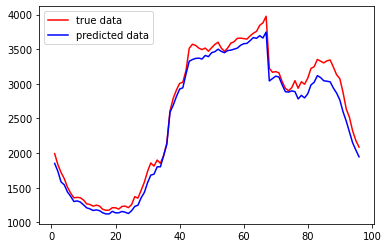

In [60]:
id = 139251010000073733
ds = date(2019, 2, 10)
plot_validate_data(id, ds)